# Module 5: Interpolation and Regression (Curve Fitting)

***Task:*** Given points
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Interpolation_Data.svg/300px-Interpolation_Data.svg.png)

we want to recover a function. For example, piecewise constant interpolation, or nearest-neighbor interpolation gives

![!](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Piecewise_constant.svg/300px-Piecewise_constant.svg.png)

or linear spline interpolation --
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Interpolation_example_linear.svg/300px-Interpolation_example_linear.svg.png)

or polynomial interpolation 
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Interpolation_example_polynomial.svg/300px-Interpolation_example_polynomial.svg.png)


## Polynomial interpolation via [Lagrange Interpolation](https://dlmf.nist.gov/3.3)

Given set of points x_given = $\{x_k\}_{k=0}^{n}$ and the value of the function at these points f_given = $\{f_k = f(x_k)\}_{k=0}^{n}$, the Lagrange interpolation polynomial $P_n(x)$ reads
$$
	P_n(x) = \sum_{k=0}^n l_k(x) f_k,
$$
where
$$
	l_k(x) = \prod_{j=0, \atop j\neq k}^n \frac{x - x_j}{x_k - x_j}.
$$

In [1]:
function lagrange_interp(x_given, f_given, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    P = zeros(length(x_eval))
    
    for k = 1:length(x_given)
       lₖ = ones(length(x_eval))
        
        for j = 1:length(x_given)
            if j ≠ k
               lₖ .*= (x_eval .- x_given[j]) ./ (x_given[k] - x_given[j])
            end
        end
        
        P .+= lₖ * f_given[k]
    end
    
    return P
end

lagrange_interp (generic function with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


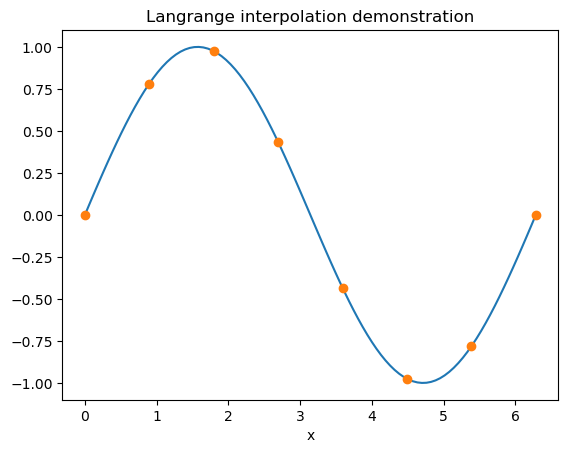

In [2]:
using PyPlot

x_given = range(0, 2 * π, 8)
f_given = sin.(x_given)

x_eval = range(0, 2 * π, 100)

title("Langrange interpolation demonstration")
plot(x_eval, lagrange_interp(x_given, f_given, x_eval))
plot(x_given, f_given, "o")
xlabel("x")
show()

## Polynomial interpolation via matrix algebra

The Lagrange interpolation polynomial can be constructed in a different way: Given the input data $\{x_k\}_{k=1}^n$ and $\{f_k = f(x_k)\}_{k=1}^n$, we need to find the coefficients $a_1, \ldots, a_n$ such that
$$
    \sum_{j=1}^n a_j x_k^{j - 1} = f_k, 
    \qquad k = 1, \ldots, n.
$$

The latter can be written as the matrix equation for the unknown vector $\begin{pmatrix} a_1 & a_2 & \ldots & a_n \end{pmatrix}^T$
$$
\underbrace{\begin{pmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^{n-1} \\
    1 & x_2 & x_2^2 & \ldots & x_2^{n-1} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^{n-1} 
\end{pmatrix}}_{\text{This is known as the Vandermonde matrix}}
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_n 
\end{pmatrix}
=
\begin{pmatrix}
    f_1 \\
    f_2 \\
    \vdots \\
    f_n 
\end{pmatrix}
$$

In [3]:
function lagrange_interp_matrix(x_given, f_given, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    n = length(x_given)
    
    # Step 1: get the Vandermonde matrix
    Vandermonde = ones(n, n)
    
    for j = 2:n
        Vandermonde[:, j] = x_given .* Vandermonde[:, j - 1]
        # this equivalent to
        # Vandermonde[:, j] = x_given .^ (j - 1)
    end
    
    # Step 2: get a's
    a = Vandermonde \ f_given
    
    # Step 3: Get the interpolated values
    P = zeros(length(x_eval))
    
    x_evalʲ⁻¹ = ones(length(x_eval))
    
    for j = 1:n
        P += a[j] *  x_evalʲ⁻¹
        x_evalʲ⁻¹ .*= x_eval
    end
    
    return P
end

lagrange_interp_matrix (generic function with 1 method)

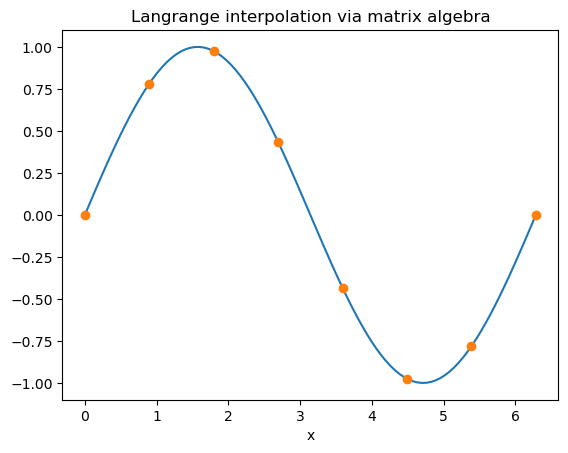

In [4]:
title("Langrange interpolation via matrix algebra")
plot(x_eval, lagrange_interp_matrix(x_given, f_given, x_eval))
plot(x_given, f_given, "o")
xlabel("x")
show()

## Not all is well -- 😱😱😱😱 [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) 😱😱😱😱

The polynomial interpolation error $\to\infty$ as $n\to\infty$ when using the equally spaced grid
$$
    f(x) = \frac{1}{\sqrt{1 + 25 x^2}},
    \qquad -1 \leq x \leq +1.
$$

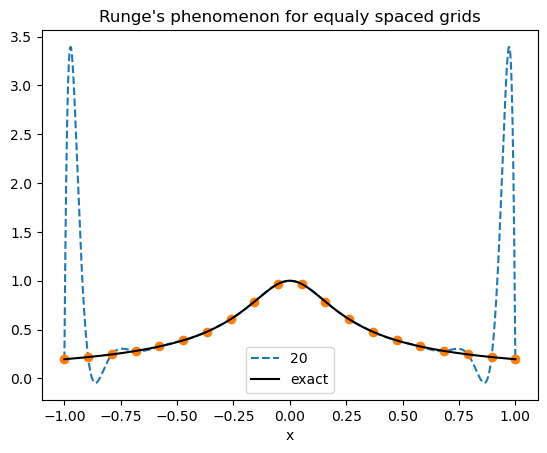

In [5]:
f(x) = 1 / sqrt(1 + 25 * x ^ 2)

x_eval = range(-1, 1, 1000)

for n = [20]#[5, 10, 15]

    x_given = range(-1, 1, n)
    
    plot(x_eval, lagrange_interp(x_given, f.(x_given), x_eval), "--", label=string(n))
    
    plot(x_given,  f.(x_given), "o")
end

title("Runge's phenomenon for equaly spaced grids")
plot(x_eval, f.(x_eval), "k", label="exact")
legend()
xlabel("x")
show()

## Orthogonal Polynomials to the rescue 🚒🚒🚒🚒🚒🚒

The coordinate grid should be chosen as the zero of an orthogonal polynomial. The [Chebyshev polynomials](https://dlmf.nist.gov/18.3) is [the best of them all](https://dlmf.nist.gov/3.11).

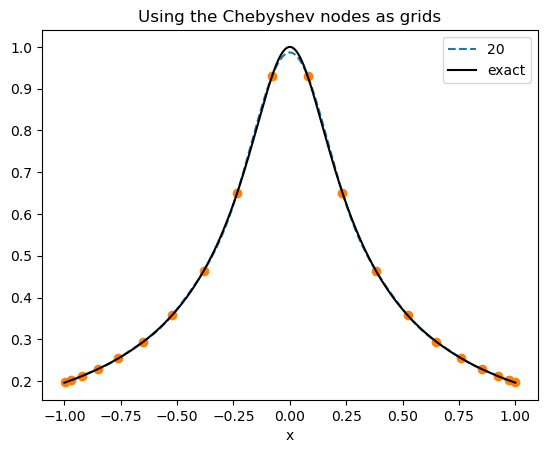

In [6]:
using FastGaussQuadrature

for n = [20]

    x_given, w = gausschebyshev(n)
    
    plot(x_eval, lagrange_interp(x_given, f.(x_given), x_eval), "--", label=string(n)) 
    
    plot(x_given,  f.(x_given), "o")
end

title("Using the Chebyshev nodes as grids")
plot(x_eval, f.(x_eval), "k", label="exact")
legend()
xlabel("x")
show()

### Check out the library [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl) and other libraries cited there for all your interpolation needs 

## Polynomial regression in 1D

Let's start with the polynomial regression in 1D.

[Regression](https://en.wikipedia.org/wiki/Regression_analysis) is a set of statistical methods for estimating the relationships between a dependent variable and one or more independent variable.

Given the input data $\{x_k\}_{k=1}^n$ and $\{f_k = f(x_k)\}_{k=1}^n$, we want to find the polynomial of the $(m-1)$-th degree $(m \leq n)$,
$$
    \sum_{j=1}^m a_j x^{j - 1}
$$
that approximates the input data. Note that when $n=m$ we recover the Lagrange interpolation polynomial

In other words, we want to find the coefficients $a_1, \ldots, a_m$ such that
$$
    \sum_{j=1}^m a_j x_k^{j - 1} \approx f_k, 
    \qquad k = 1, \ldots, n.
$$

What do we mean by ``$\approx$''? **The least square error minimization**


$$
    error^2 = \sum_{k=1}^n \left(\sum_{j=1}^m a_j x_k^{j - 1} - f_k\right)^2 \to \min.
$$

The latter can be written in the following form for the unknown vector $\begin{pmatrix} a_1 & a_2 & \ldots & a_m \end{pmatrix}^T$
$$
error^2 = \left\|\mbox{$n$ rows } 
    \underbrace{\left\{\begin{pmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^{m-1} \\
    1 & x_2 & x_2^2 & \ldots & x_2^{m-1} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^{m-1} 
\end{pmatrix}\right.}_{\mbox{$m$ columns}}
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_m 
\end{pmatrix}
-
\begin{pmatrix}
    f_1 \\
    f_2 \\
    \vdots \\
    f_n 
\end{pmatrix}
\right\|_2^2 \to \min,
$$
here $\| {\bf y} \|_2 = \sqrt{\sum_{k=1}^n y_k^2}$ is the ``length'' of the vector ${\bf y}$, i.e., [the vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)).

In [7]:
function poly_regression(x_given, f_given, m::Int, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    n = length(x_given)
    
    # Step 1: get matrix X
    X = ones(n, m)
    
    for j = 2:m
        X[:, j] = x_given .* X[:, j - 1]
        # this equivalent to
        # X[:, j] = x_given .^ (j - 1)
    end
        
    # Step 2: get a's
    a = X \ f_given
    
    println(a)
    
    # Step 3: Perform regression
    P = zeros(length(x_eval))
    
    x_evalʲ⁻¹ = ones(length(x_eval))
    
    for j = 1:m
        P += a[j] *  x_evalʲ⁻¹
        x_evalʲ⁻¹ .*= x_eval
    end
    
    return P
end

poly_regression (generic function with 1 method)

[-0.2687203687738773, 2.390758838927198, 6.181970786759178, -10.16026432656437, -7.34522694808632, 12.649465419048246, 3.132662163285972, -5.375488117280356, -0.4076807444415724, 0.7011937660962179]


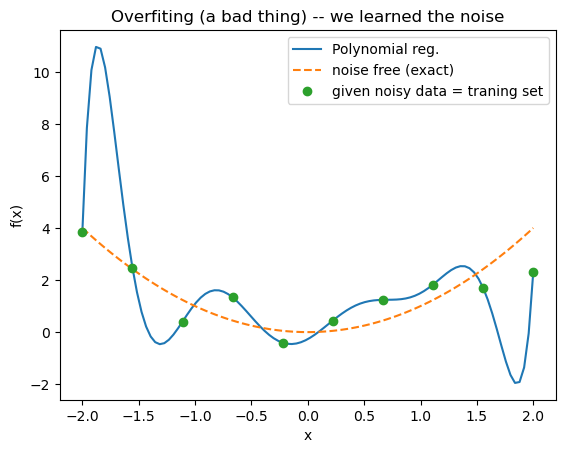

In [8]:
using Random
Random.seed!(926491)

f_exact(x) = x ^ 2

x_given = range(-2, 2, 10)
f_given = f_exact.(x_given) + randn(length(x_given))

x_eval = range(-2, 2, 100)    

title("Overfiting (a bad thing) -- we learned the noise")
plot(x_eval, poly_regression(x_given, f_given, 10, x_eval), label="Polynomial reg.")
plot(x_eval, f_exact.(x_eval), "--", label="noise free (exact)")
plot(x_given, f_given, "o", label="given noisy data = traning set")
legend()
xlabel("x")
ylabel("f(x)")
show()

[0.42142829678736843, -0.15832744311195793, 0.6705629480370493]


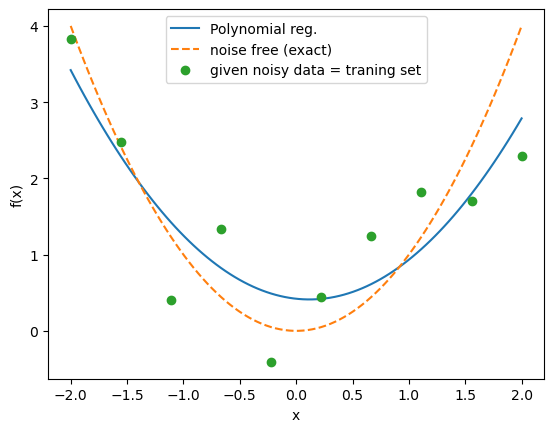

In [9]:
#title("Overfiting (a bad thing) -- we learned the noise")
plot(x_eval, poly_regression(x_given, f_given, 3, x_eval), label="Polynomial reg.")
plot(x_eval, f_exact.(x_eval), "--", label="noise free (exact)")
plot(x_given, f_given, "o", label="given noisy data = traning set")
legend()
xlabel("x")
ylabel("f(x)")
show()

[1.5141975454403376]
[1.5141975454403382, -0.15832744311195793]
[0.42142829678736843, -0.15832744311195793, 0.6705629480370493]
[0.42142829678736804, 0.551348430875714, 0.6705629480370493, -0.2452378233489822]
[0.3418169287726208, 0.5513484308757137, 0.8417552254114183, -0.2452378233489821, -0.0422761416686703]
[0.3418169287726217, 0.8137875834268965, 0.8417552254114176, -0.516782537398768, -0.042276141668670164, 0.05321400444685322]
[0.1856893471927162, 0.813787583426898, 1.6146653639233723, -0.5167825373987689, -0.5775344436861692, 0.05321400444685333, 0.08864593812222892]
[0.1856893471927166, -0.16950157045737882, 1.6146653639233703, 1.6934491899792379, -0.5775344436861679, -1.1287327605462512, 0.08864593812222882, 0.17295580093631716]
[-0.26872036877386946, -0.16950157045738598, 6.181970786759279, 1.693449189979264, -7.345226948086538, -1.1287327605462674, 3.1326621632860787, 0.17295580093632004, -0.4076807444415874]
[-0.2687203687738773, 2.390758838927198, 6.181970786759178, -10.1

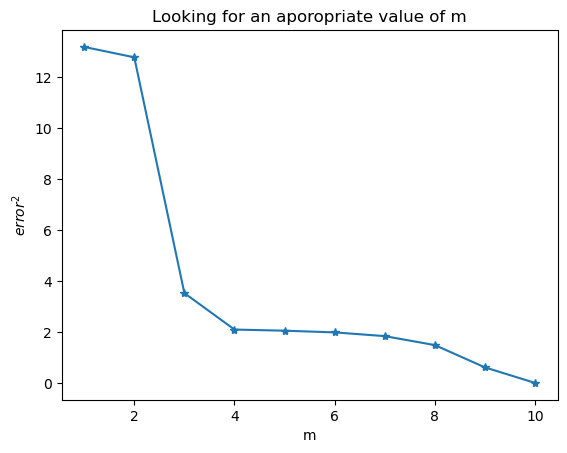

In [10]:
error² = [
    sum((poly_regression(x_given, f_given, m, x_given) - f_given) .^ 2)
        for m = 1:10
]

title("Looking for an aporopriate value of m")
plot(1:10, error², "*-")
xlabel("m")
ylabel(L"error^2")
show()

$$
    m = 3 \Longrightarrow P(x) = a_1 + a_2 x + a_3 x^2
$$

In [11]:
poly_regression(x_given, f_given, 3, x_given)

[0.42142829678736843, -0.15832744311195793, 0.6705629480370493]


10-element Vector{Float64}:
 3.4203349751594816
 2.290312193668459
 1.4252031694266418
 0.8250079024340289
 0.4897263926906208
 0.4193586401964172
 0.6139046449514184
 1.0733644069556243
 1.7977379262090347
 2.78702520271165

## Lasso regression or [Compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing)

Find the unknown parameters $a_1, \ldots, a_m$ such that
$$
\underbrace{\left\|
   X
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_m 
\end{pmatrix}
-
\begin{pmatrix}
    y_1 \\
    y_2 \\
    \vdots \\
    y_n 
\end{pmatrix}
\right\|_2^2}_{error^2 - \text{The least square error minimization}} 
+ \underbrace{\alpha \left\| 
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_m 
\end{pmatrix}
\right\|_1}_{\text{The regularizer}}
\to \min,
$$
$\alpha > 0$ and $\| {\bf a} \|_1 = \sum_{k=1}^m |a_k|$ is called the $L^1$ vector norm.

**Why is it good?** Lasso minimization forces many $a_k$ to be zero.

The larger the $\alpha$, the more unknowns $a_k$ will be set to zero (i.e., more sparsity), but the larger the error will be. The smaller the $\alpha$ the least error will be obtained at the price of many non-zero unknowns. 

Below, we will use the python library [scikit-learn](https://scikit-learn.org/stable/index.html).

In [12]:
using ScikitLearn


@sk_import linear_model: Lasso

[ Info: Running `conda install -y -c conda-forge llvm-openmp` in root environment


Solving environment: ...working... done

# All requested packages already installed.



PyObject <class 'sklearn.linear_model._coordinate_descent.Lasso'>

In [13]:
X = [x_given .^ 0 x_given x_given .^2 x_given .^ 3]

reg = fit!(Lasso(alpha = 0.5, fit_intercept=false), X, f_given)

PyObject Lasso(alpha=0.5, fit_intercept=False)

In [14]:
a = reg.coef_

4-element Vector{Float64}:
  0.0
 -0.0
  0.7101679792337394
 -0.05181549600445344

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


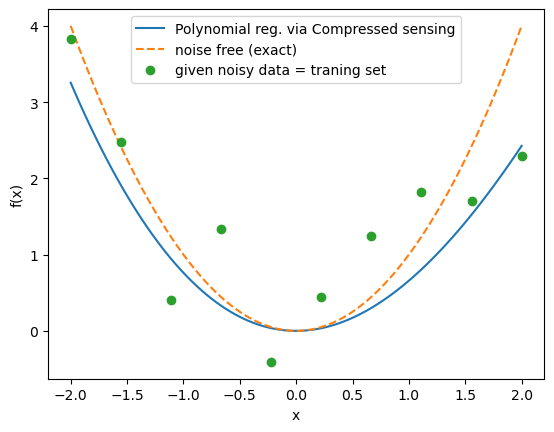

In [15]:
plot(
    x_eval, 
    sum(a[j] * x_eval .^ (j - 1) for j = 1:length(a)), 
    label="Polynomial reg. via Compressed sensing"
)
plot(x_eval, f_exact.(x_eval), "--", label="noise free (exact)")
plot(x_given, f_given, "o", label="given noisy data = traning set")
legend()
xlabel("x")
ylabel("f(x)")
show()

## Regression of data with errors: $\chi^2$ minimization

Assume we are given the values $f_k$ with errors $\Delta f_k$, then we need to perform the $\chi^2$ minimization

$$
    \chi^2 = \sum_{k=1}^n \frac{1}{\Delta f_k^2} \left(\sum_{j=1}^m a_j x_k^{j - 1} - f_k\right)^2 \to \min.
$$

Note that if all the points have the same error $\Delta f^2$, i.e., $\Delta f_k = \Delta f$ then 
$$
\chi^2 = \frac{1}{\Delta f^2} error^2 \to \min,
$$
we recovered the previously discussed least square error minimization formulation. 

In [16]:
error = abs.(f_exact.(x_given) - f_given)

10-element Vector{Float64}:
 0.1713862221199336
 0.059964966011644805
 0.8311308820670652
 0.8897940995312246
 0.4568519465465476
 0.3961355456945629
 0.7953714195726602
 0.5932899401307017
 0.7201729485028849
 1.7093348135972808

In [17]:
@sk_import linear_model: LinearRegression

[ Info: Running `conda install -y -c conda-forge llvm-openmp` in root environment


Solving environment: ...working... done

# All requested packages already installed.



PyObject <class 'sklearn.linear_model._base.LinearRegression'>

In [18]:
X = [x_given .^ 0 x_given x_given .^2 x_given .^ 3]

reg = fit!(LinearRegression(fit_intercept=false), X, f_given, sample_weight = error .^ -2)

PyObject LinearRegression(fit_intercept=False)

In [19]:
a = reg.coef_

4-element Vector{Float64}:
  0.3367175934837006
 -0.031236211229834943
  0.8006678865798732
 -0.03708954851255104

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


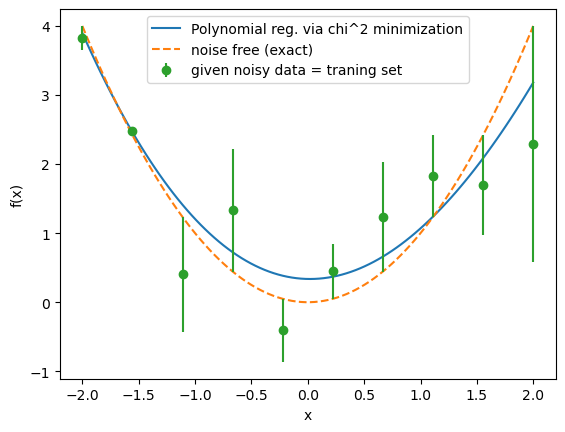

In [20]:
plot(
    x_eval, 
    sum(a[j] * x_eval .^ (j - 1) for j = 1:length(a)), 
    label="Polynomial reg. via chi^2 minimization"
)
plot(x_eval, f_exact.(x_eval), "--", label="noise free (exact)")
errorbar(x_given, f_given, yerr = error, fmt="o", label="given noisy data = traning set")
legend()
xlabel("x")
ylabel("f(x)")
show()